# Getting started: simulation of intensity modulation direct-detection (IM/DD) with On-Off Keying (OOK)

In this notebook, a basic illustrative example of the usage of the OptiCommPy package is presented. 

## Defining the IM/DD model to be simulated

A schematic for the transmission system to be simulated is shown in the figure below. 

<img src="./figures/BasicIMDD.png" width=500 height=200 />

It consists of a 10 Gb/s NRZ OOK transmission over 100 km of optical fiber with direct detection at the receiver assuming a photodiode with 10 GHz of bandwidth. The fiber channel is modeled as a linear propagation medium exhibiting loss and chromatic dispersion. All the simulation parameters are listed in the table below.

| Parameter                               | Value         |
|-----------------------------------------|---------------|
| Order of the modulation format ($M$)   | 2             |
| Symbol rate ($R_s$)                    | 10 Gb/s       |
| Pulse shape                             | NRZ           |
| Laser output power ($P_i$)             | $3$ dBm       |
| MZM $V_\pi$ voltage                    | 2.0 V         |
| MZM bias voltage ($V_b$)               | -1.0 V        |
| Total link distance ($L$)              | 100 km        |
| Fiber loss parameter ($\alpha$)        | 0.2 dB/km     |
| Fiber dispersion parameter ($D$)       | 16 ps/nm/km   |
| Central optical frequency ($F_c$)      | $193.1$ THz   |
| Photodiode bandwidth ($B$)             | $10$ GHz      |
| Simulation sampling rate ($F_s$)       | 160 GSamples/s|



## Simulating a basic IM/DD model

To build the corresponding simulation setup with OptiCommPy, first the necessary functions need to be imported as

In [1]:
import numpy as np
from optic.models.devices import mzm, photodiode
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.comm.metrics import bert
from optic.dsp.core import firFilter, pulseShape, upsample, pnorm
from optic.utils import parameters, dBm2W
from scipy.special import erfc
import matplotlib.pyplot as plt

Given that each element in the simulation requires a specific set of parameters, the subsequent step involves defining all necessary parameters to establish the desired simulation setup, as illustrated in the next cell. 

In this particular example, we assume that the electrical signal driving the optical modulator is a binary non-return-to-zero (NRZ) signal. The optical modulator is modeled as an ideal Mach-Zehnder Modulator (MZM). The fiber channel is considered linear and affected only by loss and chromatic dispersion. Lastly, at the receiver, a photodiode with a frequency response limited to 10 GHz is configured, subject to the influence of thermal and shot noise.

In [2]:
# simulation parameters
SpS = 16  # samples per symbol
M = 2  # order of the modulation format
Rs = 10e9  # Symbol rate
Fs = SpS * Rs  # Signal sampling frequency (samples/second)
Pi_dBm = 3  # laser optical power at the input of the MZM in dBm
Pi = dBm2W(Pi_dBm)  # convert from dBm to W

# typical NRZ pulse
pulse = pulseShape("nrz", SpS)
pulse = pulse / max(abs(pulse))  # normalize to 1 Vpp

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi / 2

# linear fiber optical channel parameters
paramCh = parameters()
paramCh.L = 100        # total link distance [km]
paramCh.alpha = 0.2    # fiber loss parameter [dB/km]
paramCh.D = 16         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs

# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

After defining all the required parameters, the core simulation code in the next cell establishes the signal flow through each OptiCommPy model, extending from the initial bit source to the direct-detection optical receiver. Starting with a pseudorandom bit sequence, the signal undergoes upsampling and pulse shaping, resulting in a series of binary non-return-to-zero (NRZ) pulses. The electrical NRZ signal then drives the MZM, biased at the quadrature point. An ideal laser generates the optical carrier, free from phase and intensity noise. This optical signal, upon exiting the MZM, traverses the linear fiber channel, where it is subjected to losses and chromatic dispersion. Finally, the signal is detected by a photodiode.

In [3]:
## Simulation
print("\nStarting simulation...", end="")

# generate pseudo-random bit sequence
np.random.seed(seed=123)  # fixing the seed to get reproducible results
bitsTx = np.random.randint(2, size=100000)

# generate 2-PAM modulated symbol sequence
symbTx = modulateGray(bitsTx, M, "pam")

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

# optical modulation
Ai = np.sqrt(Pi)  # ideal cw laser constant envelope
sigTxo = mzm(Ai, sigTx, paramMZM)

# linear fiber channel model
sigCh = linearFiberChannel(sigTxo, paramCh)

# noisy PD (thermal noise + shot noise + bandwidth limit)
I_Rx = photodiode(sigCh, paramPD)

# capture samples in the middle of signaling intervals
I_Rx = I_Rx[0::SpS]

print("simulation completed.")


Starting simulation...simulation completed.


After detecting the optical signal and getting the corresponding photocurrent ```I_Rx```, signal quality metrics can then be evaluated in order to quantify the transmission performance. For OOK optical transmission systems, the most common metrics are the BER and the quality-factor (Q-factor), which can be calculated from the ```I_Rx``` using the function ```bert``` available from ```optic.comm.metrics```.

In [4]:
# calculate the BER and Q-factor
BER, Q = bert(I_Rx)

print("\nTransmission performance metrics:")
print(f"Q-factor = {Q:.2f} ")
print(f"BER = {BER:.2e}")

# theoretical error probability from Q-factor
Pb = 0.5 * erfc(Q / np.sqrt(2))
print(f"Pb = {Pb:.2e}\n")


Transmission performance metrics:
Q-factor = 3.49 
BER = 2.80e-04
Pb = 2.44e-04



## Generating BER vs Pin Q vs Pin curves

Starting from this basic setup, we can conduct a comprehensive analysis via Monte Carlo simulations to characterize transmission performance across various system parameters. For instance, by repeating the same simulation with different optical launch powers and transmission distances, we can generate performance curves that depict BER and Q-factor as functions of received optical power at varying transmission distances. The corresponding code is shown in the next cell.

In [5]:
from tqdm.notebook import tqdm

# simulation parameters
SpS = 16        # Samples per symbol
M = 2           # order of the modulation format
Rs = 10e9       # Symbol rate (for the OOK case, Rs = Rb)
Fs = SpS*Rs     # Signal sampling frequency (samples/second)
Ts = 1/Fs       # Sampling period

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# linear fiber optical channel parameters
paramCh = parameters()
paramCh.L = 100  # total link distance [km]
paramCh.alpha = 0.2  # fiber loss parameter [dB/km]
paramCh.D = 16  # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs

# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

powerValues = np.arange(-30, -9) # power values at the input of the pin receiver
distances = np.arange(100, 160,10) # distances

BER = np.zeros((len(distances), len(powerValues)))
Q = np.zeros((len(distances), len(powerValues)))

for indL, L in enumerate(tqdm(distances)):
    paramCh.L = L  # total link distance [km]
    for indPi, Pi_dBm in enumerate(powerValues):        
        Pi = dBm2W(Pi_dBm + L*paramCh.alpha + 3) # optical signal power in W at the MZM input

        # generate pseudo-random bit sequence
        np.random.seed(seed=123)  # fixing the seed to get reproducible results
        bitsTx = np.random.randint(2, size=10**5)
        n = np.arange(0, bitsTx.size)

        # generate ook modulated symbol sequence
        symbTx = modulateGray(bitsTx, M, 'pam')    
        symbTx = pnorm(symbTx) # power normalization

        # upsampling
        symbolsUp = upsample(symbTx, SpS)

        # pulse formatting
        sigTx = firFilter(pulse, symbolsUp)

        # optical modulation
        Ai = np.sqrt(Pi)
        sigTxo = mzm(Ai, sigTx, paramMZM)

        # linear fiber channel model
        sigCh = linearFiberChannel(sigTxo, paramCh)

        # pin receiver
        I_Rx = photodiode(sigCh.real, paramPD)
        I_Rx = I_Rx/np.std(I_Rx)

        # capture samples in the middle of signaling intervals
        I_Rx = I_Rx[0::SpS]

        # calculate the BER and Q-factor
        BER[indL, indPi], Q[indL, indPi] = bert(I_Rx)

#         print(f'\nPin = {Pi_dBm:.2f} dBm')
#         print('\nReceived signal parameters:')
#         print(f'Q-factor = {Q[indL, indPi]:.2f} ')
#         print(f'BER = {BER[indL, indPi]:.2e}')

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_29680\2042705777.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(Prx, np.log10(BER[indL,:]),'--', marker=markers[indL], label=f'{L} km')


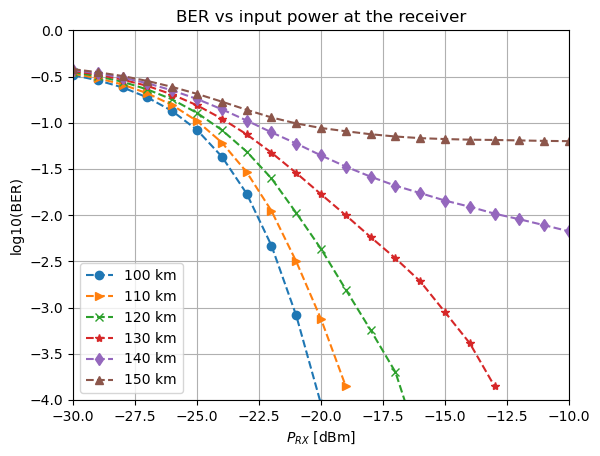

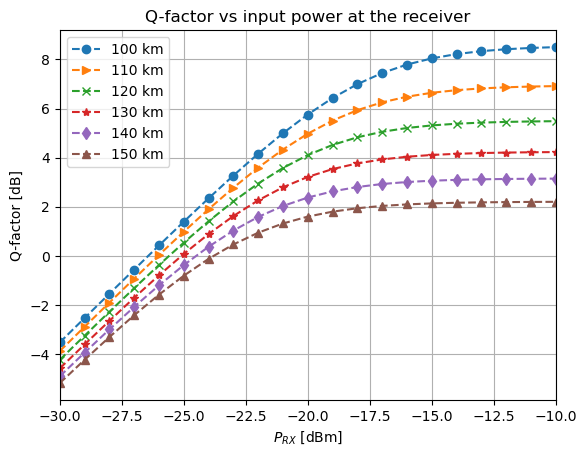

In [6]:
markers = ['o','>','x','*','d','^']

Prx = powerValues #- paramCh.L*paramCh.alpha

plt.figure()
for indL, L in enumerate(distances):
   # Prx = powerValues - L*paramCh.alpha
    plt.plot(Prx, np.log10(BER[indL,:]),'--', marker=markers[indL], label=f'{L} km')

plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('$P_{RX}$ [dBm]')
plt.title('BER vs input power at the receiver')
plt.legend()
plt.ylim(-4,0)
plt.xlim(min(Prx), max(Prx))
plt.show()

plt.figure()
for indL, L in enumerate(distances):
   # Prx = powerValues - L*paramCh.alpha
    plt.plot(Prx, 10*np.log10(Q[indL,:]),'--', marker=markers[indL], label=f'{L} km')

plt.grid()
plt.ylabel('Q-factor [dB]')
plt.xlabel('$P_{RX}$ [dBm]')
plt.title('Q-factor vs input power at the receiver')
plt.legend()
#plt.ylim(-10,0)
plt.xlim(min(Prx), max(Prx))
plt.show()

These plots clearly illustrate that system performance deteriorates with longer transmission distances, which is primarily attributed to the cumulative impact of chromatic dispersion and the noise sources at the photodiode, resulting in increased signal degradation.